<a href="https://colab.research.google.com/github/Zardian18/Celeb-Faces-Variational-Autoencoder/blob/master/VAE_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders: Celeb Face Attributes

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-03 00:32:47--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-03 00:32:47 (23.7 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Dataset

In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:09<00:00, 205MB/s]
100% 1.33G/1.33G [00:09<00:00, 148MB/s]


In [8]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from helper import sample_batch, display, get_vector_from_label, add_vector_to_images, morph_faces
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K

In [10]:
train_data = utils.image_dataset_from_directory(
    "/content/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(64, 64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [11]:
train_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [12]:
def preprocess_img(img):
  img = tf.cast(img, "float32")/255.0
  return img

In [13]:
train = train_data.map(lambda x: preprocess_img(x))

In [14]:
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [15]:
train_sample = sample_batch(train)

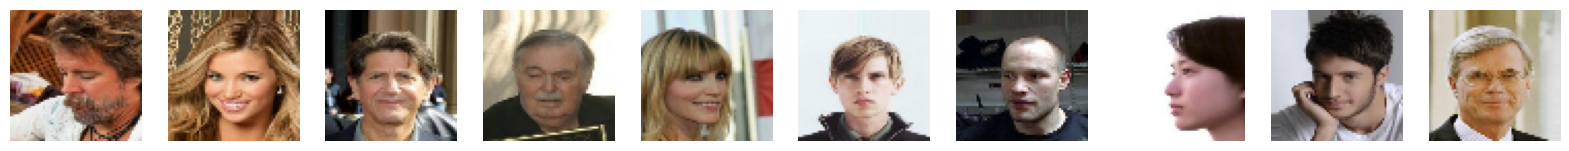

In [16]:
display(train_sample, cmap=None)

## Encoder

In [17]:
class Sampling(models.Model):
  def call(self, inputs):
    z_mean, z_log_var= inputs
    batch= tf.shape(z_mean)[0]
    dim= tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var)* epsilon

In [18]:
encoder_input= layers.Input(shape=(64,64,3), name="encoder_input")

x= layers.Conv2D(128, 3, strides=2, padding="same")(encoder_input)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(128, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(128, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(128, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(128, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

shape_before_flatten= x.shape[1:]

x= layers.Flatten()(x)
z_mean= layers.Dense(256, name="z_mean")(x)
z_log_var= layers.Dense(256, name="z_log_var")(x)
z= Sampling()([z_mean, z_log_var])

encoder= models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normalization[0]

## Decoder

In [19]:
decoder_input= layers.Input(shape=(256,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

decoder_output= layers.Conv2DTranspose(3, 3, strides=1, padding="same", activation="sigmoid")(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 128)         147584    
 anspose)                                                  

In [20]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                2000 * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            2000 * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [21]:
vae= VAE(encoder, decoder)

In [22]:
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005))

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import norm

### Callbacks

In [24]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [25]:
!mkdir output

In [26]:
vae.fit(train, epochs=15, callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=256)])

Epoch 1/15
   6/1583 [..............................] - ETA: 3:55 - loss: 379.6534 - reconstruction_loss: 236.7208 - kl_loss: 94.7158 

1583/1583 [==============================] - ETA: 0s - loss: 98.1617 - reconstruction_loss: 65.4099 - kl_loss: 15.7927

1583/1583 [==============================] - 238s 140ms/step - loss: 98.1510 - reconstruction_loss: 65.4099 - kl_loss: 15.7927
Epoch 2/15
1583/1583 [==============================] - ETA: 0s - loss: 69.2519 - reconstruction_loss: 52.7349 - kl_loss: 15.9512

1583/1583 [==============================] - 218s 137ms/step - loss: 69.2515 - reconstruction_loss: 52.7349 - kl_loss: 15.9512
Epoch 3/15
1583/1583 [==============================] - ETA: 0s - loss: 67.4398 - reconstruction_loss: 50.7269 - kl_loss: 16.2767

1583/1583 [==============================] - 219s 138ms/step - loss: 67.4395 - reconstruction_loss: 50.7269 - kl_loss: 16.2767
Epoch 4/15
1583/1583 [==============================] - ETA: 0s - loss: 66.0738 - reconstruction_loss: 49.1432 - kl_loss: 16.6257

1583/1583 [==============================] - 218s 138ms/step - loss: 66.0736 - reconstruction_loss: 49.1432 - kl_loss: 16.6257
Epoch 5/15
1583/1583 [==============================] - ETA: 0s - loss: 65.2080 - reconstruction_loss: 48.1174 - kl_loss: 16.8990

1583/1583 [==============================] - 217s 137ms/step - loss: 65.2079 - reconstruction_loss: 48.1174 - kl_loss: 16.8990
Epoch 6/15
1583/1583 [==============================] - ETA: 0s - loss: 64.6949 - reconstruction_loss: 47.5333 - kl_loss: 17.0447

1583/1583 [==============================] - 218s 137ms/step - loss: 64.6948 - reconstruction_loss: 47.5333 - kl_loss: 17.0447
Epoch 7/15
1583/1583 [==============================] - ETA: 0s - loss: 64.4178 - reconstruction_loss: 47.1353 - kl_loss: 17.1487

1583/1583 [==============================] - 219s 138ms/step - loss: 64.4178 - reconstruction_loss: 47.1353 - kl_loss: 17.1487
Epoch 8/15
1583/1583 [==============================] - ETA: 0s - loss: 64.1297 - reconstruction_loss: 46.7486 - kl_loss: 17.2637

1583/1583 [==============================] - 219s 138ms/step - loss: 64.1296 - reconstruction_loss: 46.7486 - kl_loss: 17.2637
Epoch 9/15
1583/1583 [==============================] - ETA: 0s - loss: 63.8825 - reconstruction_loss: 46.4764 - kl_loss: 17.3399

1583/1583 [==============================] - 220s 139ms/step - loss: 63.8825 - reconstruction_loss: 46.4764 - kl_loss: 17.3399
Epoch 10/15
1583/1583 [==============================] - ETA: 0s - loss: 63.7160 - reconstruction_loss: 46.2007 - kl_loss: 17.4073

1583/1583 [==============================] - 218s 138ms/step - loss: 63.7160 - reconstruction_loss: 46.2007 - kl_loss: 17.4073
Epoch 11/15
1583/1583 [==============================] - ETA: 0s - loss: 63.5324 - reconstruction_loss: 45.9771 - kl_loss: 17.4703

1583/1583 [==============================] - 220s 139ms/step - loss: 63.5324 - reconstruction_loss: 45.9771 - kl_loss: 17.4703
Epoch 12/15
1583/1583 [==============================] - ETA: 0s - loss: 63.3825 - reconstruction_loss: 45.7802 - kl_loss: 17.5275

1583/1583 [==============================] - 218s 138ms/step - loss: 63.3825 - reconstruction_loss: 45.7802 - kl_loss: 17.5275
Epoch 13/15
1583/1583 [==============================] - ETA: 0s - loss: 63.1977 - reconstruction_loss: 45.5029 - kl_loss: 17.6116

1583/1583 [==============================] - 220s 139ms/step - loss: 63.1976 - reconstruction_loss: 45.5029 - kl_loss: 17.6116
Epoch 14/15
1583/1583 [==============================] - ETA: 0s - loss: 63.1118 - reconstruction_loss: 45.3380 - kl_loss: 17.6936

1583/1583 [==============================] - 217s 137ms/step - loss: 63.1117 - reconstruction_loss: 45.3380 - kl_loss: 17.6936
Epoch 15/15
1583/1583 [==============================] - ETA: 0s - loss: 63.0168 - reconstruction_loss: 45.2139 - kl_loss: 17.7280

1583/1583 [==============================] - 222s 140ms/step - loss: 63.0167 - reconstruction_loss: 45.2139 - kl_loss: 17.7280


## Reconstructing

In [27]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 10ms/step
Example Images


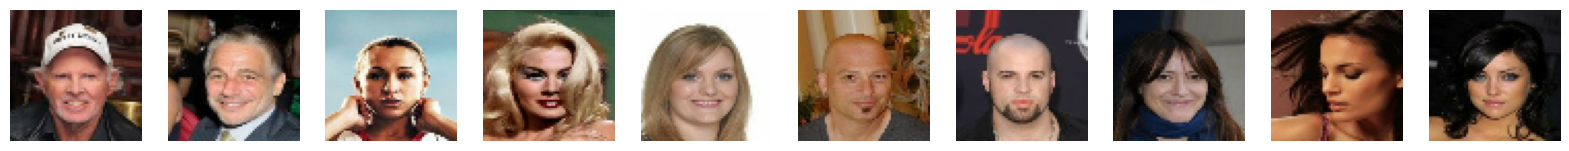

Recosntructed Images


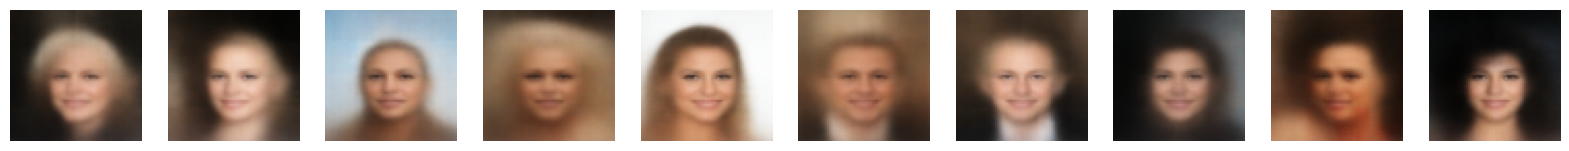

In [28]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions)

4/4 [==============================] - 0s 3ms/step


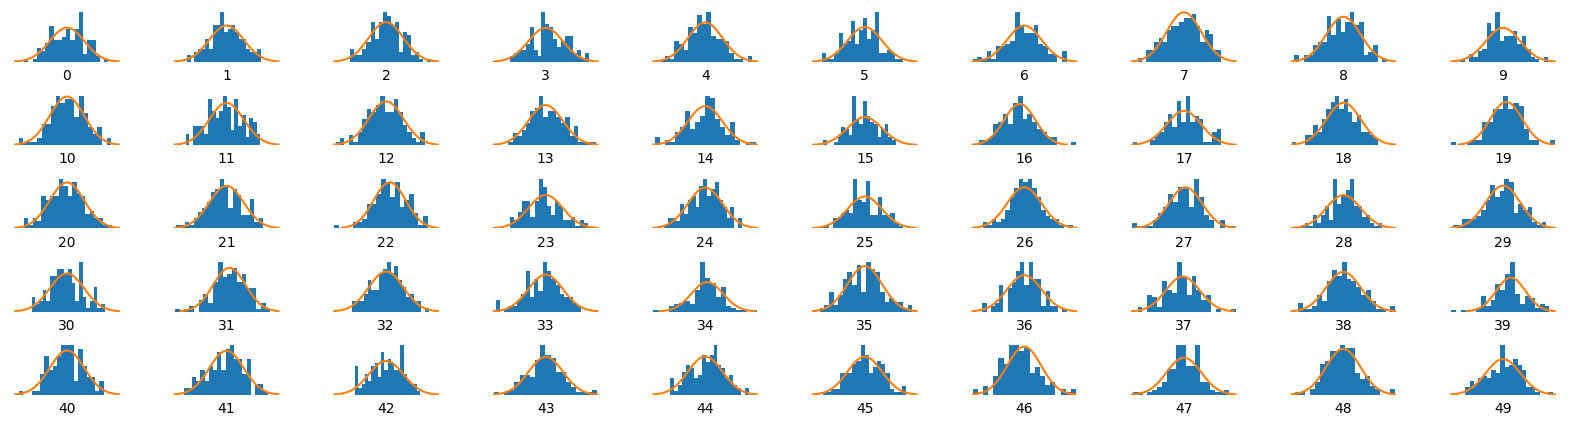

In [29]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## Generating new faces

1/1 [==============================] - 1s 946ms/step


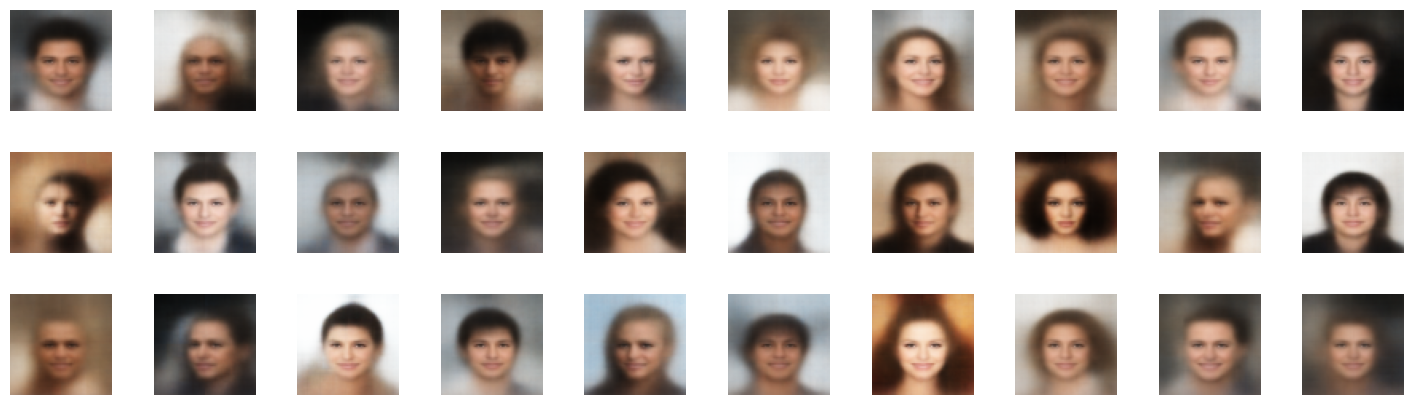

In [30]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_width*grid_height, 256)) # 10*3 new embeddings

reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width*grid_height):
  ax= fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis(False)
  ax.imshow(reconstructions[i])

In [31]:
reconstructions[0].shape

(64, 64, 3)

## Manipulating the images

In [32]:
attributes = pd.read_csv("/content/list_attr_celeba.csv")
attributes.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [33]:
attributes.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

Loading data with a specific feature

### Turning image hair to gray

In [34]:
LABEL= "Gray_Hair"

In [35]:
labelled_test= utils.image_dataset_from_directory(
    "/content/img_align_celeba/img_align_celeba",
    labels= attributes[LABEL].to_list(),
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset= "validation",
    interpolation="bilinear"
)

labelled= labelled_test.map(lambda x, y: (preprocess_img(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [36]:
labelled

<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
attribute_vec= get_vector_from_label(labelled, vae, 256, LABEL)

label: Gray_Hair
images : POS move : NEG move :distance : 𝛥 distance
1    : 17.169    : 1.606    : 17.178    : 17.178
3    : 13.121    : 1.043    : 9.765    : -7.413
10    : 8.214    : 0.597    : 5.607    : -4.158
15    : 3.126    : 0.416    : 4.588    : -1.02
17    : 1.402    : 0.316    : 4.278    : -0.31
24    : 2.099    : 0.271    : 3.793    : -0.485
31    : 1.542    : 0.213    : 3.43    : -0.363
35    : 1.005    : 0.199    : 3.208    : -0.223
39    : 0.913    : 0.169    : 3.06    : -0.148
45    : 0.902    : 0.153    : 2.938    : -0.122
49    : 0.7    : 0.14    : 2.837    : -0.101
52    : 0.554    : 0.123    : 2.785    : -0.052
58    : 0.704    : 0.107    : 2.695    : -0.09
62    : 0.544    : 0.105    : 2.685    : -0.01
67    : 0.538    : 0.1    : 2.626    : -0.059
71    : 0.441    : 0.093    : 2.574    : -0.052
75    : 0.438    : 0.086    : 2.54    : -0.035
79    : 0.43    : 0.083    : 2.523    : -0.017
83    : 0.388    : 0.079    : 2.451    : -0.072
86    : 0.342    : 0.076    : 2

In [38]:
attribute_vec

array([ 1.8213404e-02, -6.8074535e-03, -1.4152443e-02,  2.5028130e-02,
       -2.6293823e-02, -3.1604387e-02,  4.3370754e-02,  5.0445064e-03,
       -2.7235946e-02, -3.0403323e-02,  8.1961211e-03, -1.3322265e-02,
        6.6545759e-03,  2.2711132e-02, -3.6004875e-02,  2.9585818e-02,
       -5.6446147e-01,  1.0538310e-02, -3.1601854e-02,  7.6470844e-04,
        2.6547676e-02,  1.1903751e-02,  7.7418804e-02,  1.6225370e-02,
        3.3360384e-02, -3.9497372e-03, -2.9501053e-02, -1.0495498e-02,
        2.0724162e-03,  6.9339871e-03,  4.3211564e-02,  1.6824991e-01,
       -5.9277704e-03,  2.4873773e-02, -1.0679266e-02,  1.4668630e-02,
       -3.8885999e-02,  3.1671356e-02, -2.0289199e-02, -5.7491865e-03,
       -5.0091155e-02, -5.2103501e-02,  4.2989798e-02,  3.2904111e-02,
        6.8083927e-02,  1.6487896e-02,  2.1110695e-02,  2.1736436e-02,
       -2.7991902e-02,  2.7406802e-02,  1.4030293e-02,  6.0707172e-03,
        3.8697958e-02,  1.1229326e-03,  2.2298573e-02,  5.1796045e-03,
      

As we can see, the hair color changes to gray because we are adding the vector responsible for this

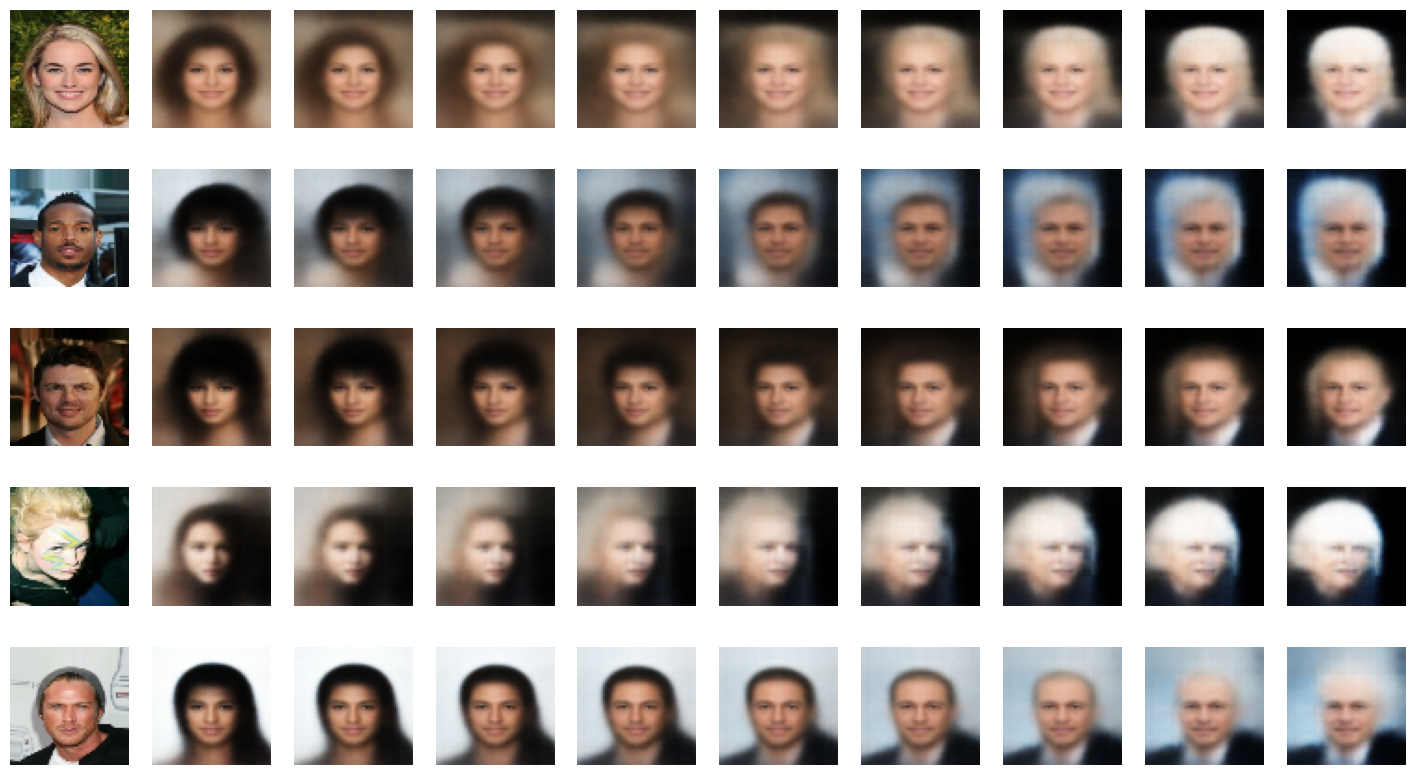

In [39]:
add_vector_to_images(labelled, vae, attribute_vec)

### Making the faces smile

In [45]:
LABEL="Smiling"

In [46]:
labelled_test= utils.image_dataset_from_directory(
    "/content/img_align_celeba/img_align_celeba",
    labels= attributes[LABEL].to_list(),
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset= "validation",
    interpolation="bilinear"
)

labelled= labelled_test.map(lambda x, y: (preprocess_img(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [47]:
attribute_vec= get_vector_from_label(labelled, vae, 256, LABEL)

label: Smiling
images : POS move : NEG move :distance : 𝛥 distance
59    : 2.127    : 2.036    : 2.943    : 2.943
120    : 1.508    : 1.365    : 2.059    : -0.884
182    : 0.816    : 0.807    : 1.822    : -0.238
236    : 0.551    : 0.61    : 1.574    : -0.248
299    : 0.471    : 0.414    : 1.449    : -0.124
364    : 0.366    : 0.342    : 1.295    : -0.154
424    : 0.327    : 0.336    : 1.177    : -0.118
490    : 0.276    : 0.248    : 1.071    : -0.106
547    : 0.221    : 0.252    : 1.017    : -0.054
605    : 0.224    : 0.216    : 1.011    : -0.006
664    : 0.199    : 0.21    : 0.976    : -0.035
721    : 0.168    : 0.179    : 0.953    : -0.023
776    : 0.159    : 0.17    : 0.922    : -0.031
834    : 0.139    : 0.142    : 0.895    : -0.027
890    : 0.146    : 0.133    : 0.898    : 0.003
957    : 0.131    : 0.119    : 0.875    : -0.022
1025    : 0.135    : 0.113    : 0.86    : -0.016
1092    : 0.133    : 0.107    : 0.838    : -0.022
1155    : 0.113    : 0.106    : 0.849    : 0.012
1202   

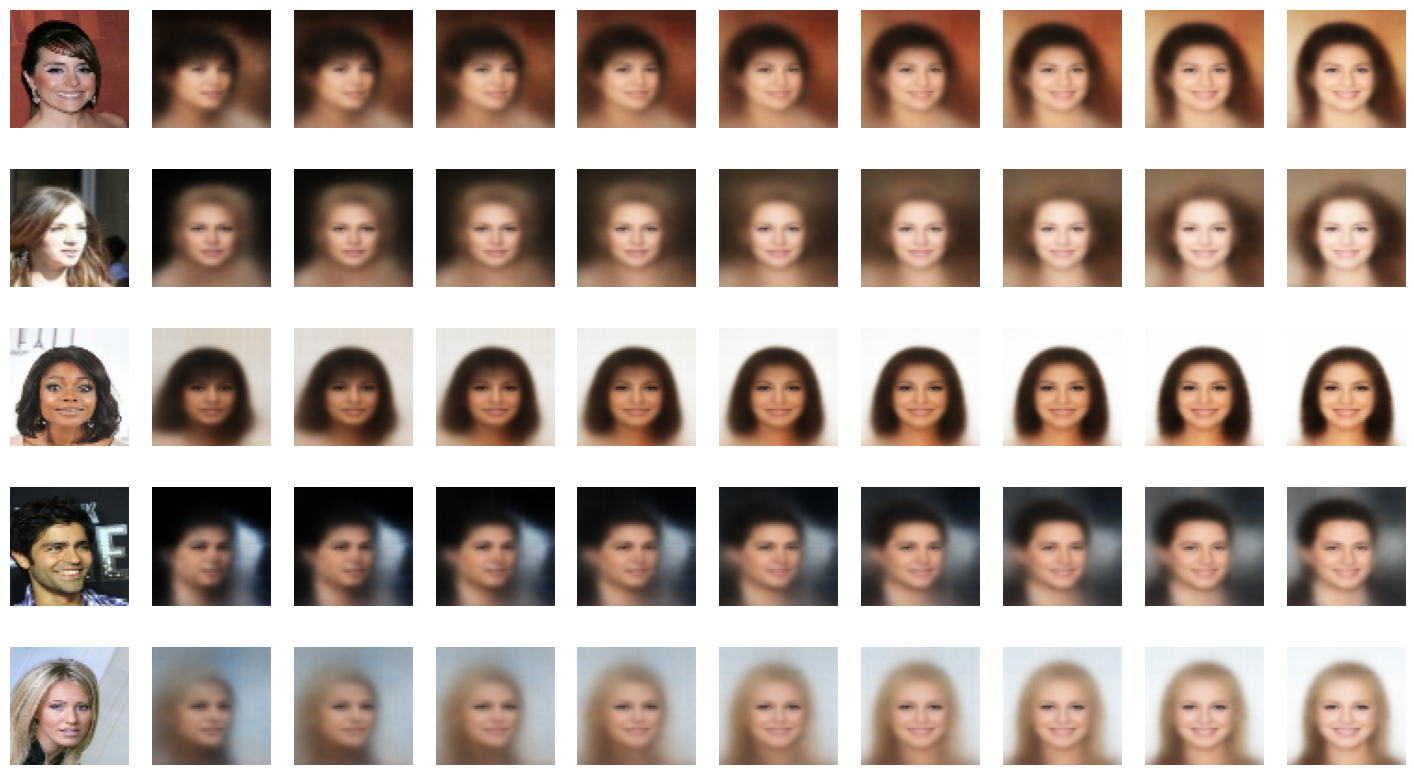

In [48]:
add_vector_to_images(labelled, vae, attribute_vec)

### Morphing faces

Here we convert face A to face B by adding the directional vector pointing towards in increment of `0.1`

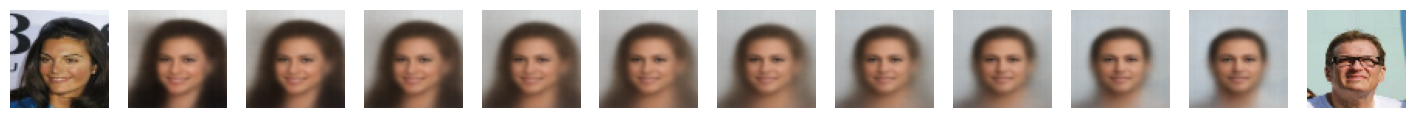

In [49]:
morph_faces(labelled, vae)

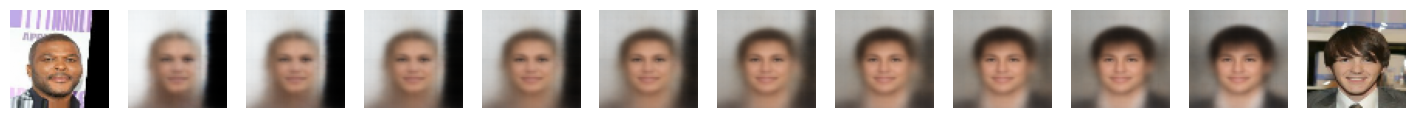

In [53]:
morph_faces(labelled, vae)